# Re-used number plates mystery...
In notebook number 2, we discovered a load of vehicles that had reused number plates. These initially appeared to be instances of errors in the database. OdometerReadings going back a long way would slowing build, nicely, monotonically and neatly, until they suddenly dropped to first-MOT levels. 

We've discovered that these vehicles had re-used number places, so the join between `mots.tests` and `mots.vehicles` was throwing up a table with bad results. In this notebook, we're going to investigate the cases of reused number plates and see what we can do about it. 

In [1]:
#We'll start by importing the usual packages we use to read the data.
import pandas_gbq
from google.oauth2 import service_account
import os
# from google.cloud import bigquery
import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt

# Any extras:
from tqdm import tqdm
import pandas as pd

In [2]:
# Credentials for BigQuery
credentials = service_account.Credentials.from_service_account_file('rugged-baton-283921-5706f65c85fe.json')

First, we're going to have a look at how many registration numbers occur more than once in `mots.vehicles`.

In [3]:
sql = """
WITH nums as (
SELECT registration, COUNT(*) as num_reused
FROM `rugged-baton-283921.mots.vehicles`
GROUP BY registration
) SELECT num_reused, COUNT(*) num_instances
FROM nums
GROUP BY num_reused;
"""

In [4]:
df = pandas_gbq.read_gbq(sql, project_id='rugged-baton-283921', credentials = credentials, progress_bar_type='tqdm')

Downloading: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56rows/s]


In [5]:
df.head(10)

,num_reused,num_instances
0,1,64290930
1,2,264764
2,3,8643
3,4,688
4,5,190
5,6,58
6,7,26
7,8,6
8,1004,1
9,11,1


In the above table, `num_reused` means the number of times a registration has been reused, and `num_instances` means the number of times that a registration has been used that many times. So:
* 264,764 registrations have been used twice
* 8,643 registrations have been used 3 times, 
* etc.

Next, we'll pull out the registrations that have been used twice. We expect there to be 529,528 results if we get the query right.

In [6]:
sql = """
WITH twices as (
    SELECT registration, COUNT(*) as num_reused
    FROM `rugged-baton-283921.mots.vehicles`
    GROUP BY registration
    HAVING num_reused = 2
) SELECT *
FROM `rugged-baton-283921.mots.vehicles` A
INNER JOIN twices B 
ON A.registration = B.registration
"""

In [7]:
df = pandas_gbq.read_gbq(sql, project_id='rugged-baton-283921', credentials = credentials, progress_bar_type='tqdm')

Downloading: 100%|████████████████████████████████████████████████████████| 529528/529528 [00:50<00:00, 10540.16rows/s]


In [8]:
df.head()

,registration,make,model,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId,jsonPage,registration_1,num_reused
0,R885UOP,LDV,None,NaT,NaT,NaT,NaN,Diesel,Red,-FcS8deZIdKtc76NYxnLKg==,58430.json,R885UOP,2
1,V481GPR,VAUHALL,None,NaT,NaT,NaT,NaN,Diesel,Red,_yeFf-QWtBFEy64i-WSqYA==,68616.json,V481GPR,2
2,R688CTU,VW,None,NaT,NaT,NaT,NaN,Petrol,Silver,gU1srDOQyB3meMvQRxKZWA==,63010.json,R688CTU,2
3,SM02PYH,MISUBISHI,None,NaT,NaT,NaT,NaN,Petrol,Silver,GFEl6HVjPp8Q439Nc5qNkQ==,61863.json,SM02PYH,2
4,S874VAG,PIAGGO,VELOFAX,1999-01-01 00:00:00+00:00,1999-01-01 00:00:00+00:00,1999-01-01 00:00:00+00:00,49.0,Petrol,Blue,xupb6paIVcaLDoXMePAhHA==,59139.json,S874VAG,2


In [31]:
# Some of those pre-1920s registration dates must be, er, problematic...
df2 = df[df['registrationDate'] > '1960-12-31 00:00:00+00:00']

<Figure size 1800x1200 with 0 Axes>

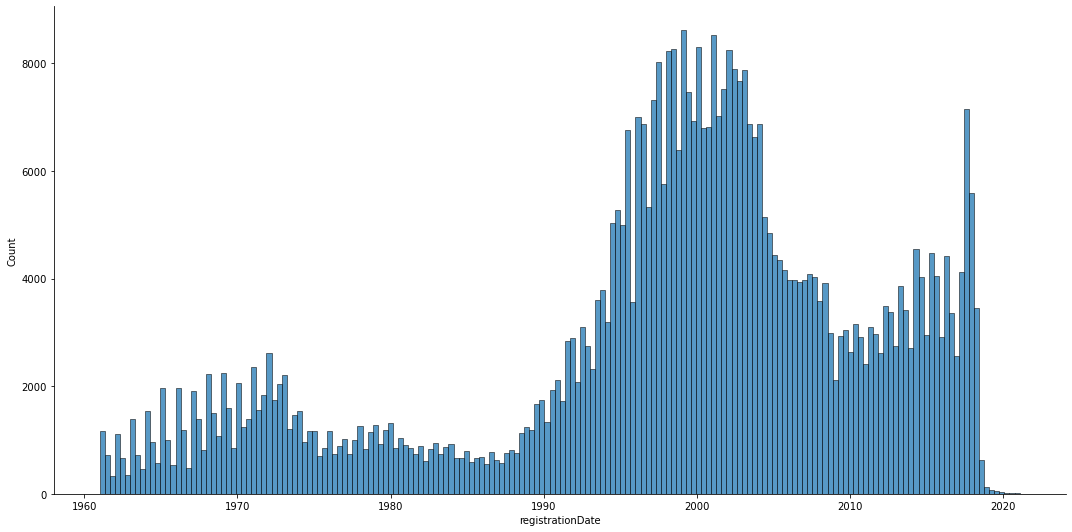

In [34]:
plt.figure(dpi = 300)
# plt.title('Distribution of registration dates of cars that have a numberplate that has been used more than twice')
sns_plot = sns.displot(data = df2 , x='registrationDate', aspect=2, height=7.5)
sns_plot.savefig('twice_regs_1.png')

Let's dig a little deper. We'll sort `df` by `registrationDate` and then assign each row (registration) a number: 1 if it is the first occurence of the registration, and 2 if it is the second occurence. 

In [11]:
df = df.sort_values('registrationDate')
df.head() 
# There are some hilarious registrationDates... 

,registration,make,model,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId,jsonPage,registration_1,num_reused
390822,694UXU,TRIUMPH,None,1858-06-09 00:00:00+00:00,1858-06-09 00:00:00+00:00,1858-06-09 00:00:00+00:00,649.0,Petrol,Silver,pWaE71CJZyvdSh5KDLrBjA==,9701.json,694UXU,2
401061,CYD550A,TRIUMPH,3TA,1863-08-01 00:00:00+00:00,1863-08-01 00:00:00+00:00,1863-08-01 00:00:00+00:00,350.0,Petrol,Black,eMzPYJDZ5HFr0S5LE0LFLA==,18716.json,CYD550A,2
393347,MLJ633F,TRIUMPH,SPITFIRE,1877-01-01 00:00:00+00:00,1877-01-01 00:00:00+00:00,1877-01-01 00:00:00+00:00,1493.0,Petrol,Purple,CFIGJJpgLmPvN_FwK9gJxw==,57682.json,MLJ633F,2
405354,PCB219S,KAWASAKI,Z650,1878-01-01 00:00:00+00:00,1878-01-01 00:00:00+00:00,1878-01-01 00:00:00+00:00,650.0,Petrol,Green,KXjOZZWZvMRZmNSKEiTbgw==,56952.json,PCB219S,2
241030,X395AVJ,ROVER,MAESTRO,1883-07-01 00:00:00+00:00,1883-07-01 00:00:00+00:00,1883-07-01 00:00:00+00:00,1275.0,Petrol,Blue,V8hFoOIt5eKEwromeOCUjw==,76755.json,X395AVJ,2


We'll create an empty list `check_list`, and an empty column, `df.num`, with all values set to 0.

We'll iterate down `df.registration`, doing three things:
* First we'll check if it's in the database already,
* If it isn't, we'll make `df.num[row] = 1`, and add the registration to `check_list`.
* If it is in the list, we'll make `df.num[row] = 2`, and move on. 

The cell below iterates through an awful lot of things. It is going to take a few minutes to run...

In [12]:
regs = df['registration'].to_list()

In [13]:
# check_list = []
# count_list = []

# df['num'] = 0
# for reg in tqdm(regs):
#     if reg not in check_list:
#         count_list.append('f')
#         check_list.append(reg)
#     elif reg in check_list:
#         count_list.append('s')
        

100%|███████████████████████████████████████████████████████████████████████| 529528/529528 [1:23:04<00:00, 106.23it/s]


In [14]:
se = pd.Series(count_list)
df['time_used'] = se.values

In [15]:
print(len(regs))
print(len(count_list))
print(len(df['registration'].to_list()))

529528
529528
529528


In [16]:
count_list[:20]

['f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f']

In [17]:
df.head()

,registration,make,model,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId,jsonPage,registration_1,num_reused,num,time_used
390822,694UXU,TRIUMPH,None,1858-06-09 00:00:00+00:00,1858-06-09 00:00:00+00:00,1858-06-09 00:00:00+00:00,649.0,Petrol,Silver,pWaE71CJZyvdSh5KDLrBjA==,9701.json,694UXU,2,0,f
401061,CYD550A,TRIUMPH,3TA,1863-08-01 00:00:00+00:00,1863-08-01 00:00:00+00:00,1863-08-01 00:00:00+00:00,350.0,Petrol,Black,eMzPYJDZ5HFr0S5LE0LFLA==,18716.json,CYD550A,2,0,f
393347,MLJ633F,TRIUMPH,SPITFIRE,1877-01-01 00:00:00+00:00,1877-01-01 00:00:00+00:00,1877-01-01 00:00:00+00:00,1493.0,Petrol,Purple,CFIGJJpgLmPvN_FwK9gJxw==,57682.json,MLJ633F,2,0,f
405354,PCB219S,KAWASAKI,Z650,1878-01-01 00:00:00+00:00,1878-01-01 00:00:00+00:00,1878-01-01 00:00:00+00:00,650.0,Petrol,Green,KXjOZZWZvMRZmNSKEiTbgw==,56952.json,PCB219S,2,0,f
241030,X395AVJ,ROVER,MAESTRO,1883-07-01 00:00:00+00:00,1883-07-01 00:00:00+00:00,1883-07-01 00:00:00+00:00,1275.0,Petrol,Blue,V8hFoOIt5eKEwromeOCUjw==,76755.json,X395AVJ,2,0,f


In [41]:
df3 = df[df['registrationDate'] > '1980-12-31 00:00:00+00:00']

<Figure size 1800x1200 with 0 Axes>

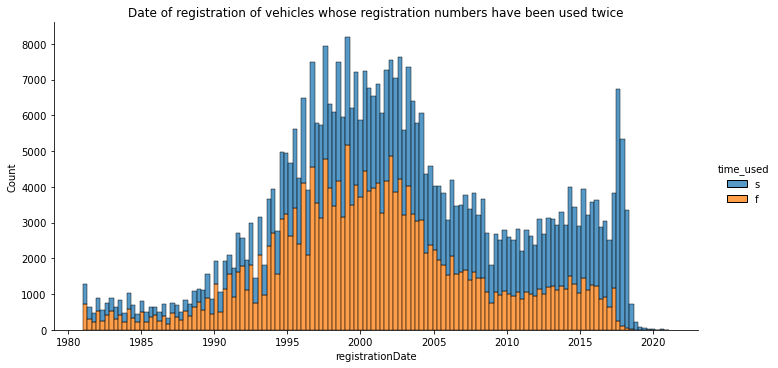

In [60]:
plt.figure(dpi=300)
sns_plot = sns.displot(data = df3 , x='registrationDate', aspect=2, height=5, hue='time_used', multiple = 'stack')
plt.title('Date of registration of vehicles whose registration numbers have been used twice')
sns_plot.savefig('twice_regs.png')


In [63]:
post_2015_regs = df[df['registrationDate'] > '2017-12-31 00:00:00+00:00']
p_2015_r_list = post_2015_regs['registration'].to_list()
df4 = df3[df3['registration'].isin(p_2015_r_list)]
df4 = df4[df4['registrationDate'] > '1990-12-31 00:00:00+00:00']

<Figure size 1800x1200 with 0 Axes>

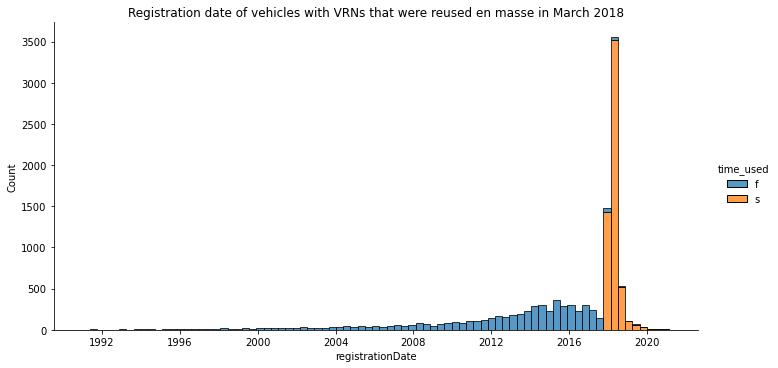

In [65]:
plt.figure(dpi=300)
sns_plot = sns.displot(data = df4 , x='registrationDate', aspect=2, height=5, hue='time_used', multiple = 'stack')
plt.title('Registration date of vehicles with VRNs that were reused en masse in March 2018')
sns_plot.savefig('twice_regs_3.png')
